In [56]:
import warnings
warnings.filterwarnings("ignore")

import os
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from glob import glob

import mne
from mne.datasets import spm_face
from mne.preprocessing import ICA, create_eog_epochs
from mne import io, combine_evoked
from mne.minimum_norm import make_inverse_operator, apply_inverse
from mne.decoding import (SlidingEstimator, GeneralizingEstimator, Scaler,
                          cross_val_multiscore, LinearModel, get_coef,
                          Vectorizer, CSP, UnsupervisedSpatialFilter)

mne.set_log_level('warning')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, permutation_test_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA


In [4]:
epoch_type = "evoked"
# epoch_type = 'pseudo-rs'

all_participants = [
    "VP07",
    "VP08",
    "VP09",
    "VP10",
    "VP11",
    "VP12",
    "VP13",
    "VP14",
    "VP18",
    "VP19",
    "VP20",
    "VP22",
    "VP23",
    "VP24",
    "VP25",
    "VP26",
    "VP27",
    "VP28",
    "VP29",
    "VP30",
    "VP31",
    "VP32",
    "VP33",
    "VP35",
    "VP36",
    "VP37",
]

# path = "/media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/"  # icm-linux
path = '/Users/nicobruno/ownCloud/MW_eeg_data/minmarker/' #nico-mac

In [46]:
allepochs = []
alllabels = []

for i in all_participants:
    participant = i
    
    folder = path + participant +'/'
    
    epochs = mne.read_epochs(folder +  participant + '_' + epoch_type + '_' +  'ar_subtracted_epo.fif') 
    epochs =  epochs.pick_types(eeg = True) #EOGs break everything\
    
    allepochs.append(epochs)

In [36]:
all_epochs = mne.concatenate_epochs(allepochs)

In [37]:
epochs_ot = all_epochs['PC/on-task/correct/go'].get_data()
epochs_mw = mne.concatenate_epochs([all_epochs['PC/dMW/correct/go'],all_epochs['PC/sMW/correct/go']]).get_data()

In [38]:
labels_ot = np.array(['ot' for i in range(len(epochs_ot))])
labels_mw = np.array(['mw' for i in range(len(epochs_mw))])

In [50]:
X = np.concatenate([epochs_mw, epochs_ot])
y = np.concatenate([labels_mw, labels_ot])

  0%|          | Fitting SlidingEstimator : 0/201 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/201 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/201 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/201 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/201 [00:00<?,       ?it/s]

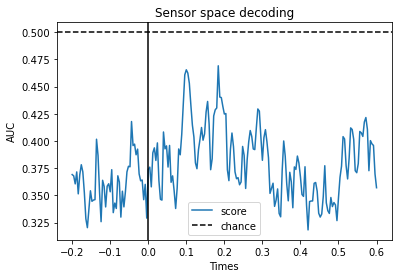

In [51]:
steps = [
    ("scaler", StandardScaler()),
    ("SVM", SVC(C=0.001, gamma=0.1, kernel="rbf", probability=True)),
]
pipe = Pipeline(steps)

#     cv = StratifiedKFold(10, shuffle=True, random_state = 42)

time_decod = SlidingEstimator(pipe, n_jobs=-1, scoring='roc_auc', verbose=True)
scores = cross_val_multiscore(time_decod, X, y, cv=5, n_jobs=1)

# Mean scores across cross-validation splits
scores = np.mean(scores, axis=0)

# Plot
fig, ax = plt.subplots()
ax.plot(epochs.times, scores, label='score')
ax.axhline(.5, color='k', linestyle='--', label='chance')
ax.set_xlabel('Times')
ax.set_ylabel('AUC')  # Area Under the Curve
ax.legend()
ax.axvline(.0, color='k', linestyle='-')
ax.set_title('Sensor space decoding')
plt.show()

(995, 64, 201)

In [60]:

steps = [
    ("scaler", StandardScaler()),
    ("SVM", SVC(C=0.001, gamma=0.1, kernel="rbf", probability=True)),
]
pipe = Pipeline(steps)
permutation_test_score(
            pipe, X, y, scoring="roc_auc", n_permutations=1000, random_state = 42
        )
            

# print(f"p_value = {pvalue}")

# plt.hist(perm_scores, bins=20, density=True)
# plt.axvline(score, ls="--", color="r")
# score_label = (
#     f"Score on original\ndata: {score:.2f}\n" f"(p-value: {pvalue:.3f})"
# )
# plt.text(score, np.max(perm_scores), score_label, fontsize=12)
# plt.xlabel("Accuracy score")
# plt.ylabel("Probability")
# plt.show()

ValueError: Found array with dim 3. StandardScaler expected <= 2.

In [53]:
# coef = get_coef(time_decod, 'patterns_', inverse_transform=True)
# evoked_time_gen = mne.EvokedArray(coef, epochs.info, tmin=epochs.times[0])
# joint_kwargs = dict(ts_args=dict(time_unit='s'),
#                     topomap_args=dict(time_unit='s'))
# evoked_time_gen.plot_joint(times=np.arange(0., .500, .100), title='patterns',
#                            **joint_kwargs)

  0%|          | Fitting GeneralizingEstimator : 0/201 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/40401 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/201 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/40401 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/201 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/40401 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/201 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/40401 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/201 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/40401 [00:00<?,       ?it/s]

Text(0.5, 1.0, 'Decoding MEG sensors over time')

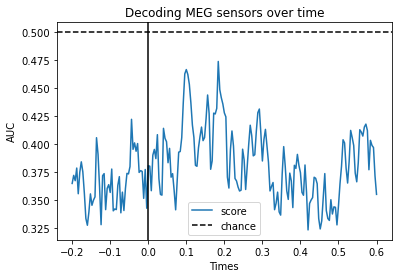

In [42]:
steps = [
    ("scaler", StandardScaler()),
    ("SVM", SVC(C=0.001, gamma=0.1, kernel="rbf", probability=True)),
]
pipe = Pipeline(steps)

time_gen = GeneralizingEstimator(pipe, n_jobs=-1, scoring='roc_auc',
                                 verbose=True)

scores = cross_val_multiscore(time_gen, X, y, cv=5, n_jobs=-1)

# Mean scores across cross-validation splits
scores = np.mean(scores, axis=0)

# Plot the diagonal (it's exactly the same as the time-by-time decoding above)
fig, ax = plt.subplots()
ax.plot(epochs.times, np.diag(scores), label='score')
ax.axhline(.5, color='k', linestyle='--', label='chance')
ax.set_xlabel('Times')
ax.set_ylabel('AUC')
ax.legend()
ax.axvline(.0, color='k', linestyle='-')
ax.set_title('Decoding MEG sensors over time')

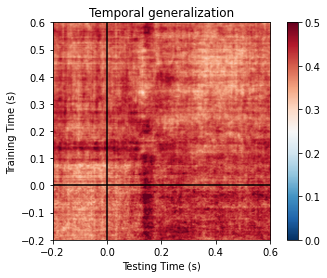

In [44]:
fig, ax = plt.subplots(1, 1)
im = ax.imshow(scores, interpolation='lanczos', origin='lower', cmap='RdBu_r',
               extent=epochs.times[[0, -1, 0, -1]], vmin=0., vmax=0.5)
ax.set_xlabel('Testing Time (s)')
ax.set_ylabel('Training Time (s)')
ax.set_title('Temporal generalization')
ax.axvline(0, color='k')
ax.axhline(0, color='k')
plt.colorbar(im, ax=ax)

# dMW vs sMW

In [68]:
epochs_smw = all_epochs['SC/dMW/correct/go'].get_data()
epochs_dmw = all_epochs['SC/sMW/correct/go'].get_data()

In [69]:
labels_smw = np.array(['ot' for i in range(len(epochs_smw))])
labels_dmw = np.array(['mw' for i in range(len(epochs_dmw))])

In [70]:
X = np.concatenate([epochs_smw, epochs_dmw])
y = np.concatenate([labels_smw, labels_dmw])

  0%|          | Fitting SlidingEstimator : 0/201 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/201 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/201 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/201 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/201 [00:00<?,       ?it/s]

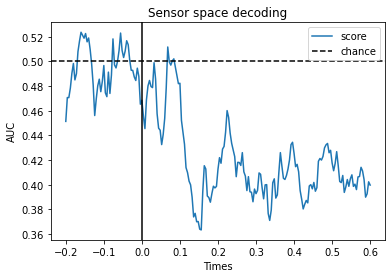

In [71]:
steps = [
    ("scaler", StandardScaler()),
    ("SVM", SVC(C=0.001, gamma=0.1, kernel="rbf", probability=True)),
]
pipe = Pipeline(steps)

#     cv = StratifiedKFold(10, shuffle=True, random_state = 42)

time_decod = SlidingEstimator(pipe, n_jobs=-1, scoring='roc_auc', verbose=True)
scores = cross_val_multiscore(time_decod, X, y, cv=5, n_jobs=1)

# Mean scores across cross-validation splits
scores = np.mean(scores, axis=0)

# Plot
fig, ax = plt.subplots()
ax.plot(epochs.times, scores, label='score')
ax.axhline(.5, color='k', linestyle='--', label='chance')
ax.set_xlabel('Times')
ax.set_ylabel('AUC')  # Area Under the Curve
ax.legend()
ax.axvline(.0, color='k', linestyle='-')
ax.set_title('Sensor space decoding')
plt.show()

In [74]:
steps = [
    ("scaler", StandardScaler()),
    ("SVM", SVC(C=0.001, gamma=0.1, kernel="rbf", probability=True)),
]
pipe = Pipeline(steps)

time_gen = GeneralizingEstimator(pipe, n_jobs=-1, scoring='roc_auc',
                                 verbose=True)

scores = cross_val_multiscore(time_gen, X, y, cv=5, n_jobs=1)

# Mean scores across cross-validation splits
scores = np.mean(scores, axis=0)

# Plot the diagonal (it's exactly the same as the time-by-time decoding above)
fig, ax = plt.subplots()
ax.plot(epochs.times, np.diag(scores), label='score')
ax.axhline(.5, color='k', linestyle='--', label='chance')
ax.set_xlabel('Times')
ax.set_ylabel('AUC')
ax.legend()
ax.axvline(.0, color='k', linestyle='-')
ax.set_title('Decoding MEG sensors over time')

  0%|          | Fitting GeneralizingEstimator : 0/201 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/40401 [00:00<?,       ?it/s]

KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(1, 1)
im = ax.imshow(scores, interpolation='lanczos', origin='lower', cmap='RdBu_r',
               extent=epochs.times[[0, -1, 0, -1]], vmin=0., vmax=0.5)
ax.set_xlabel('Testing Time (s)')
ax.set_ylabel('Training Time (s)')
ax.set_title('Temporal generalization')
ax.axvline(0, color='k')
ax.axhline(0, color='k')
plt.colorbar(im, ax=ax)